In [91]:
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import normalize


import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [92]:
headers = ['age', 'sex', 'white', 'asian', 'black', 'hispanic', 'otherRace', 'gpa', 'SAT', 'SATWriting', 'APTests', 'APScores', 'STEM', 'essays', 'extracurriculars', 'percentile', 'collegeLevel', 'collegeScore', 'accepted']
# header_type = [int, bool, bool,    bool,    bool,    bool,       bool,       float,  int,    float,       int,       float,      bool,   float,    int,               float,         int,              float,        bool]

n_extra_var = 7
n_latent_var = 8
for i in range(n_extra_var):
    headers.insert(-3,'var_'+str(i))

In [93]:
df = pd.read_csv("college_acceptance_10001_gaussian.csv", index_col=0)
df.drop(df.index[-1],inplace=True)

In [94]:
print(df.columns)

Index(['age', 'sex', 'white', 'asian', 'black', 'hispanic', 'otherRace', 'gpa',
       'SAT', 'SATWriting', 'APTests', 'APScores', 'STEM', 'essays',
       'extracurriculars', 'percentile', 'var_0', 'var_1', 'var_2', 'var_3',
       'var_4', 'var_5', 'var_6', 'collegeLevel', 'collegeScore', 'accepted'],
      dtype='object')


In [95]:
# Exogenous: 'age', 'sex', 'white', 'asian', 'black', 'hispanic', 'otherRace', 'percentile'
# Endogenous: (Dependencies)
#   Percentile: 'SAT', 'SATWriting', 'APTests', 'APScores', 'STEM', 'essays', 'extracurriculars', 'collegeLevel'
#   Application Data: 'collegeScore'
#   collegeScore: 'accepted'

In [111]:
X_headers = ['age', 'sex', 'white', 'asian', 'black', 'hispanic', 'otherRace', 'STEM', 'percentile', 'collegeLevel']
C_headers = ['gpa', 'SAT', 'SATWriting', 'APTests', 'APScores', 'essays', 'extracurriculars']
C_headers_missing = ['gpa', 'SAT', 'SATWriting', 'APTests', 'APScores', 'extracurriculars']
Y_headers = ['accepted']
CY_headers = ['gpa', 'SAT', 'SATWriting', 'APTests', 'APScores', 'essays', 'extracurriculars','accepted']

X = df.loc[:,X_headers].values
# C = df.loc[:,C_headers].values
# y = df.loc[:,Y_headers].values
Cy = df.loc[:,CY_headers].values
Cy_norm = Cy / np.max(Cy, axis=0)
X_train, X_test, Cy_train, Cy_test = train_test_split(X, Cy_norm, train_size=.7)
# C_train = Cy_train[:,:-1]
# y_train = Cy_train[:,-1]
# C_test = Cy_test[:,:-1]
# y_test = Cy_test[:,-1]


In [112]:
train_X = torch.Tensor(X_train)
train_Cy = torch.Tensor(Cy_train)
test_X = torch.Tensor(X_test)
test_Cy = torch.Tensor(Cy_test)
training_dataset = TensorDataset(train_X, train_Cy)
train_loader = DataLoader(training_dataset, batch_size=1024, shuffle=True)
testing_dataset = TensorDataset(test_X, test_Cy)
test_loader = DataLoader(testing_dataset, batch_size=1024, shuffle=True)

In [113]:
x_to_c_model = nn.Sequential(nn.Linear(len(X_headers), 32),
                      nn.ReLU(),
                      nn.Linear(32,32),
                      nn.ReLU(),
                      nn.Linear(32,32),
                      nn.ReLU(),
                      nn.Linear(32, len(C_headers))).to(device)
print(x_to_c_model)

Sequential(
  (0): Linear(in_features=10, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=32, bias=True)
  (5): ReLU()
  (6): Linear(in_features=32, out_features=7, bias=True)
)


In [114]:
loss_function = nn.MSELoss()

learning_rate = 0.001
optimizer = torch.optim.Adam(x_to_c_model.parameters(), lr=learning_rate)
attr_criterion = []
for _ in range(len(C_headers)):
    attr_criterion.append(nn.MSELoss())

In [115]:
def train_one_epoch(epoch_index):
    running_loss = 0.
    last_loss = 0.
    for batch, data in enumerate(train_loader):
        inputs, labels = data
        inputs = inputs.to(device)
        concepts = labels[:,:-1].to(device)

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = x_to_c_model(inputs)

        # Compute the loss and its gradients
        # loss = loss_function(outputs, concepts)
        
        losses = []
        for j in range(len(attr_criterion)):
            losses.append(attr_criterion[j](outputs[j], concepts[j]))
        loss = sum(losses) / len(attr_criterion)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if batch % 4 == 0:
            last_loss = running_loss / 100 # loss per batch
            print('  batch {} loss: {}'.format(batch + 1, last_loss))
            tb_x = epoch_index * len(train_loader) + i + 1
            running_loss = 0.

    return last_loss

EPOCHS = 50
losses = []

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch))

    # Make sure gradient tracking is on, and do a pass over the data
    x_to_c_model.train(True)
    avg_loss = train_one_epoch(epoch)
    losses.append(avg_loss)

    # We don't need gradients on to do reporting
    x_to_c_model.train(False)

EPOCH 0:
  batch 1 loss: 0.005000687837600708
  batch 5 loss: 0.016685579717159272
  batch 9 loss: 0.009357297420501709
  batch 13 loss: 0.0060707186162471775
  batch 17 loss: 0.004230905473232269
EPOCH 1:
  batch 1 loss: 0.0008680988848209381
  batch 5 loss: 0.003247593492269516
  batch 9 loss: 0.0030208250135183336
  batch 13 loss: 0.0023204968124628067
  batch 17 loss: 0.001530750058591366
EPOCH 2:
  batch 1 loss: 0.0002943214401602745
  batch 5 loss: 0.0013579592108726502
  batch 9 loss: 0.001169162131845951
  batch 13 loss: 0.0012779508717358113
  batch 17 loss: 0.001162359081208706
EPOCH 3:
  batch 1 loss: 0.0003375997394323349
  batch 5 loss: 0.0012685955874621867
  batch 9 loss: 0.0012403399124741555
  batch 13 loss: 0.0007601229753345251
  batch 17 loss: 0.0011595746129751206
EPOCH 4:
  batch 1 loss: 0.0006049774587154388
  batch 5 loss: 0.0013200653716921805
  batch 9 loss: 0.0011773349530994892
  batch 13 loss: 0.0013902800716459752
  batch 17 loss: 0.0010607038252055646
EPO

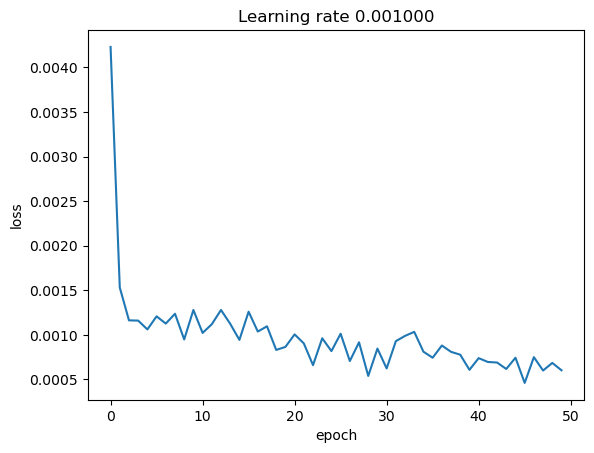

In [116]:
plt.plot(losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title("Learning rate %f"%(learning_rate))
plt.show()

In [117]:
# testing
running_loss = 0.
last_loss = 0.
for batch, data in enumerate(test_loader):
    inputs, labels = data
    inputs = inputs.to(device)
    concepts = labels[:,:-1].to(device)

    # Make predictions for this batch
    outputs = x_to_c_model(inputs)

    # Compute the loss and its gradients
    # loss = loss_function(outputs, concepts)
    
    losses = []
    for j in range(len(attr_criterion)):
        losses.append(attr_criterion[j](outputs[j], concepts[j]))
    loss = sum(losses) / len(attr_criterion)

    # Display
    outputs = outputs.cpu().detach().numpy()
    inputs_empty = np.empty(inputs.shape)
    inputs_empty.fill(np.nan)
    predictions = np.concatenate((inputs_empty, outputs * np.max(Cy[:,:-1], axis=0)), axis=1)
    inputs_test = np.concatenate((inputs.cpu().detach().numpy(), concepts.cpu().detach().numpy() * np.max(Cy[:,:-1], axis=0)), axis=1)
    result = np.hstack([inputs_test,predictions]).reshape(predictions.shape[0]*2, predictions.shape[1])
    test_headers = list(X_headers)
    test_headers.extend(C_headers)
    df_test = pd.DataFrame(result, columns=test_headers)
    display(df_test)
    break

    # Gather data and report
    running_loss += loss.item()
    if batch % 1 == 0:
        last_loss = running_loss / 100 # loss per batch
        print('  batch {} loss: {}'.format(batch + 1, last_loss))
        running_loss = 0.

,age,sex,white,asian,black,hispanic,otherRace,STEM,percentile,collegeLevel,gpa,SAT,SATWriting,APTests,APScores,essays,extracurriculars
0,16.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.882712,1.0,4.077786,1513.162422,7.474613,3.000000,3.592015,0.852421,2.954657
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.804067,1482.728958,5.954553,3.173607,3.671115,0.792061,3.192034
2,17.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.477677,1.0,3.714489,1402.688885,4.160025,0.000000,2.355543,0.363163,1.081171
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.503166,1384.743404,4.923130,1.494872,2.973150,0.602498,1.127307
4,17.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.419183,0.0,2.856713,1172.551727,4.764175,0.000000,2.377683,0.419974,1.766646
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2043,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.226370,1542.563248,6.645649,4.830593,4.206120,0.979301,4.291906
2044,18.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.770523,0.0,3.819935,1329.424095,4.073002,2.000000,3.292308,0.934312,0.000000
2045,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.712922,1510.413837,5.454598,1.464087,3.282853,0.650245,1.170252
2046,18.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.716003,2.0,3.718977,1503.100109,5.394302,1.000000,2.971605,0.542494,0.404006


In [ ]:
# clf = tree.DecisionTreeClassifier()
# clf = LogisticRegression(random_state=0)
# clf = SVC(kernel="linear", C=0.025, random_state=42)
# clf = SVC(gamma=2, C=1, random_state=42)
# clf = RandomForestClassifier(random_state=42)
# clf = clf.fit(X_train, y_train)

In [ ]:
# y_pred = clf.predict(X_test)
# print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7451388967167525


<Figure size 1400x1400 with 0 Axes>

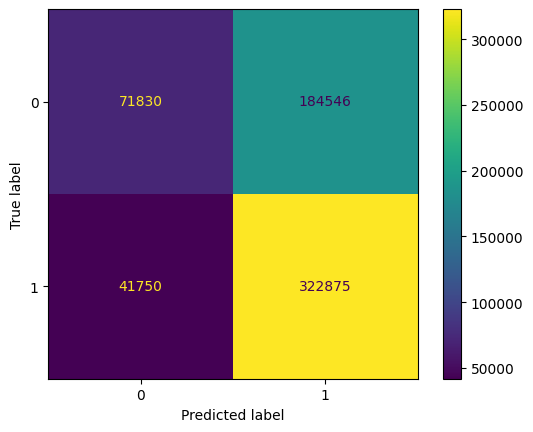

In [ ]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
plt.figure(figsize=(14,14))
disp.plot()
plt.show()

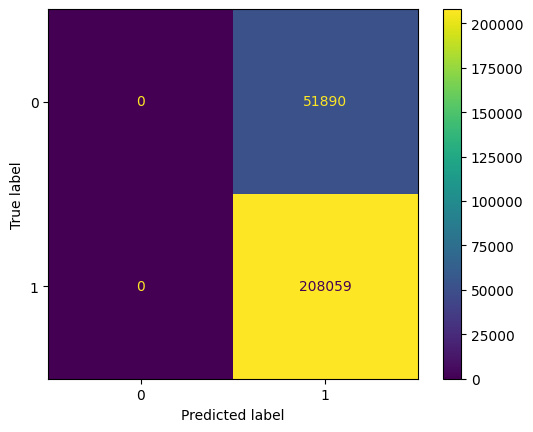

In [ ]:
y_test0 = y_test[np.in1d(X_test[:, -1], [0])]
y_pred0 = y_pred[np.in1d(X_test[:, -1], [0])]
cm = confusion_matrix(y_test0, y_pred0)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

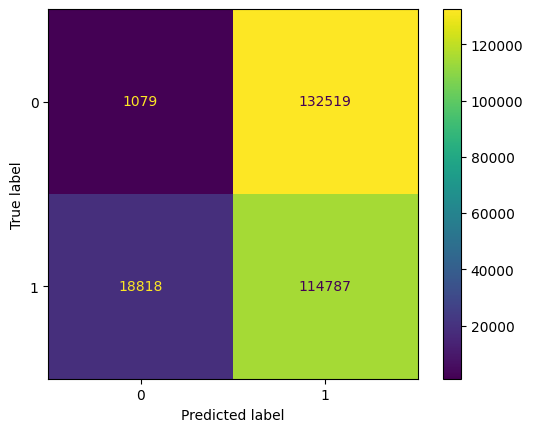

In [ ]:
y_test1 = y_test[np.in1d(X_test[:, -1], [1])]
y_pred1 = y_pred[np.in1d(X_test[:, -1], [1])]
cm = confusion_matrix(y_test1, y_pred1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

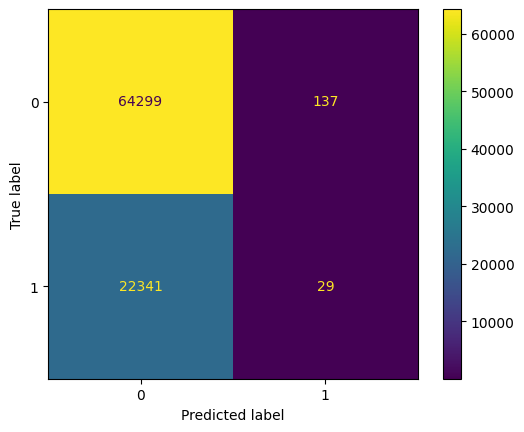

In [ ]:
y_test2 = y_test[np.in1d(X_test[:, -1], [2])]
y_pred2 = y_pred[np.in1d(X_test[:, -1], [2])]
cm = confusion_matrix(y_test2, y_pred2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

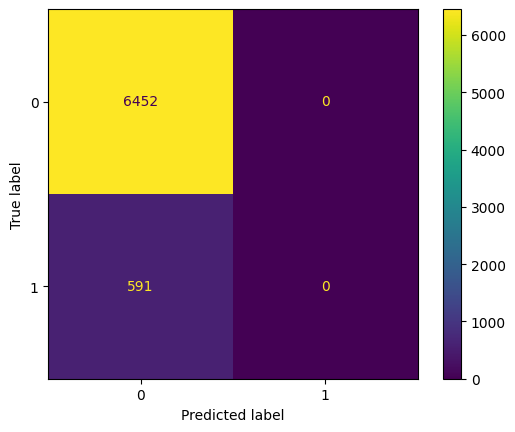

In [ ]:
y_test3 = y_test[np.in1d(X_test[:, -1], [3])]
y_pred3 = y_pred[np.in1d(X_test[:, -1], [3])]
cm = confusion_matrix(y_test3, y_pred3)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [ ]:
# plt.figure(figsize=(400,14))
# tree.plot_tree(clf, max_depth=8,fontsize=7, feature_names=headers_final)
# plt.savefig('tree_high_dpi', dpi=100)